## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, save_model

from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import train_test_split

## Load CIFAR-10 dataset


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
print('Training data shape:', X_train.shape)

print('Size of training data: ', X_train.shape[0])
print('Size of testing data: ', X_test.shape[0])


Training data shape: (50000, 32, 32, 3)
Size of training data:  50000
Size of testing data:  10000


## Data Pre-processing

In [4]:
# Perform one-hot encoding
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10) 

In [5]:
# Convert to Float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Perform Normalization
X_train /= 255
X_test /= 255

## Split the training data into training and validation sets


In [6]:
X_train_set, X_val, Y_train_set, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

## Perform DATA AUGMENTATION

In [7]:
batch_size = 128
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, zoom_range=0.2)
train_generator = data_generator.flow(X_train_set, Y_train_set, batch_size)

## Experiment 1

### Build model

In [8]:
def create_Model1(k, dr, lr):
    
    i = Input(shape = (32, 32, 3))

    x = Conv2D(32, (k,k), activation= 'relu', padding='same')(i)
    x = Conv2D(32, (k,k), activation= 'relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(dr)(x)

    x = Conv2D(64, (k,k), activation= 'relu', padding='same')(x)
    x = Conv2D(64, (k,k), activation= 'relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(dr)(x)

    x = Flatten()(x)
    
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dr)(x)

    x = Dense(10, activation='softmax')(x)
    
    model = Model(i,x)
    
    opt = keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
    

    return model

### Model summary with filter size as 3x3, dropout rate as 0.20 and learning rate as 0.01

In [9]:
create_Model1(3, 0.20, 0.01).summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                           

### Perform hyper-parameter tuning

In [10]:
filter_sizes = [3, 5]
dropout_rates = [0.2, 0.35, 0.5]
learning_rates = [0.01, 0.001, 0.0001]

In [11]:
results = {}

for filter_size in filter_sizes:
    
    for dropout_rate in dropout_rates:
        
        for learning_rate in learning_rates:
            
            results[filter_size, dropout_rate, learning_rate] = {'accuracy': None,  'loss': None, 'history': None}


In [12]:
best_combination = [ [0, 0, 0], [0, 0, None] ]

In [13]:
for filter_size in filter_sizes:
    
    for dropout_rate in dropout_rates:
        
        for learning_rate in learning_rates:
            
            print("\n" + f"COMBINATION: filter_size={filter_size}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
            
            # Initialise batch size, steps per epoch, number of epochs
            batch_size = 128
            steps_per_epoch = X_train_set.shape[0] // batch_size
            num_epochs = 40

             # Define Callback
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1,  restore_best_weights=True)

            # Define the ModelCheckpoint callback
            checkpoint_callback = ModelCheckpoint(
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1,
                filepath='cnn_model.h5'
            )
                
            # Build the model
            model = create_Model1(filter_size, dropout_rate, learning_rate)
            
            # Train CNN on the training data
            r = model.fit(train_generator, validation_data=(X_val, Y_val), steps_per_epoch=steps_per_epoch, epochs = num_epochs, batch_size=batch_size, callbacks=[checkpoint_callback, callback])

            # Load the best model
            best_model = load_model('cnn_model.h5')
            
            # Evaluate on the validation data
            val_loss, val_accuracy = best_model.evaluate(X_val, Y_val)

            results[filter_size, dropout_rate, learning_rate] = {'accuracy': val_accuracy,  'loss': val_loss, 'history': r}
            
            print("COMBINATION BEST ACCURACY: ", val_accuracy)
            
            if val_accuracy > best_combination[1][0]:
                best_combination = [ [filter_size, dropout_rate, learning_rate], [val_accuracy, val_loss, r] ]

            



COMBINATION: filter_size=3, dropout_rate=0.2, learning_rate=0.01
Epoch 1/40


312/312 [==============================] - ETA: 0s - loss: 2.5431 - accuracy: 0.0984
Epoch 1: val_accuracy improved from -inf to 0.09330, saving model to cnn_model.h5
312/312 [==============================] - 45s 139ms/step - loss: 2.5431 - accuracy: 0.0984 - val_loss: 2.3036 - val_accuracy: 0.0933
Epoch 2/40


C:\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312/312 [==============================] - ETA: 0s - loss: 2.3034 - accuracy: 0.0987
Epoch 2: val_accuracy improved from 0.09330 to 0.10300, saving model to cnn_model.h5
312/312 [==============================] - 42s 134ms/step - loss: 2.3034 - accuracy: 0.0987 - val_loss: 2.3027 - val_accuracy: 0.1030
Epoch 3/40
312/312 [==============================] - ETA: 0s - loss: 2.3031 - accuracy: 0.1015
Epoch 3: val_accuracy did not improve from 0.10300
312/312 [==============================] - 42s 135ms/step - loss: 2.3031 - accuracy: 0.1015 - val_loss: 2.3038 - val_accuracy: 0.0933
Epoch 4/40
312/312 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.0985
Epoch 4: val_accuracy improved from 0.10300 to 0.10400, saving model to cnn_model.h5
312/312 [==============================] - 54s 173ms/step - loss: 2.3032 - accuracy: 0.0985 - val_loss: 2.3034 - val_accuracy: 0.1040
Epoch 5/40
312/312 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.1007
Epoc

312/312 [==============================] - 44s 142ms/step - loss: 0.7462 - accuracy: 0.7374 - val_loss: 0.6825 - val_accuracy: 0.7700
Epoch 20/40
312/312 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.7414
Epoch 20: val_accuracy improved from 0.77000 to 0.77520, saving model to cnn_model.h5
312/312 [==============================] - 44s 139ms/step - loss: 0.7349 - accuracy: 0.7414 - val_loss: 0.6618 - val_accuracy: 0.7752
Epoch 21/40
312/312 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.7474
Epoch 21: val_accuracy did not improve from 0.77520
312/312 [==============================] - 43s 139ms/step - loss: 0.7195 - accuracy: 0.7474 - val_loss: 0.7610 - val_accuracy: 0.7489
Epoch 22/40
312/312 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.7485
Epoch 22: val_accuracy did not improve from 0.77520
312/312 [==============================] - 43s 139ms/step - loss: 0.7204 - accuracy: 0.7485 - val_loss: 0.6857 - val_

Epoch 18/40
312/312 [==============================] - ETA: 0s - loss: 1.1754 - accuracy: 0.5809
Epoch 18: val_accuracy did not improve from 0.61490
312/312 [==============================] - 45s 143ms/step - loss: 1.1754 - accuracy: 0.5809 - val_loss: 1.1306 - val_accuracy: 0.6040
Epoch 19/40
312/312 [==============================] - ETA: 0s - loss: 1.1646 - accuracy: 0.5851
Epoch 19: val_accuracy improved from 0.61490 to 0.64500, saving model to cnn_model.h5
312/312 [==============================] - 44s 142ms/step - loss: 1.1646 - accuracy: 0.5851 - val_loss: 1.0083 - val_accuracy: 0.6450
Epoch 20/40
312/312 [==============================] - ETA: 0s - loss: 1.1417 - accuracy: 0.5951
Epoch 20: val_accuracy did not improve from 0.64500
312/312 [==============================] - 44s 140ms/step - loss: 1.1417 - accuracy: 0.5951 - val_loss: 1.0500 - val_accuracy: 0.6360
Epoch 21/40
312/312 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.5980
Epoch 21: val_accura

Epoch 5/40
312/312 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.0997
Epoch 5: val_accuracy did not improve from 0.10230
312/312 [==============================] - 43s 138ms/step - loss: 2.3032 - accuracy: 0.0997 - val_loss: 2.3033 - val_accuracy: 0.1017
Epoch 6/40
312/312 [==============================] - ETA: 0s - loss: 2.3033 - accuracy: 0.1017
Epoch 6: val_accuracy did not improve from 0.10230
312/312 [==============================] - 43s 138ms/step - loss: 2.3033 - accuracy: 0.1017 - val_loss: 2.3036 - val_accuracy: 0.0973
Epoch 7/40
312/312 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.1009
Epoch 7: val_accuracy did not improve from 0.10230
312/312 [==============================] - 43s 137ms/step - loss: 2.3032 - accuracy: 0.1009 - val_loss: 2.3027 - val_accuracy: 0.1015
Epoch 8/40
312/312 [==============================] - ETA: 0s - loss: 2.3033 - accuracy: 0.1003
Epoch 8: val_accuracy did not improve from 0.10230
Restoring 

312/312 [==============================] - 44s 142ms/step - loss: 1.6072 - accuracy: 0.4120 - val_loss: 1.4316 - val_accuracy: 0.4840
Epoch 5/40
312/312 [==============================] - ETA: 0s - loss: 1.5594 - accuracy: 0.4336
Epoch 5: val_accuracy did not improve from 0.48400
312/312 [==============================] - 43s 139ms/step - loss: 1.5594 - accuracy: 0.4336 - val_loss: 1.4382 - val_accuracy: 0.4824
Epoch 6/40
312/312 [==============================] - ETA: 0s - loss: 1.5203 - accuracy: 0.4477
Epoch 6: val_accuracy did not improve from 0.48400
312/312 [==============================] - 43s 139ms/step - loss: 1.5203 - accuracy: 0.4477 - val_loss: 1.4352 - val_accuracy: 0.4754
Epoch 7/40
312/312 [==============================] - ETA: 0s - loss: 1.4760 - accuracy: 0.4657
Epoch 7: val_accuracy improved from 0.48400 to 0.49200, saving model to cnn_model.h5
312/312 [==============================] - 44s 139ms/step - loss: 1.4760 - accuracy: 0.4657 - val_loss: 1.4142 - val_accura

Epoch 32/40
312/312 [==============================] - ETA: 0s - loss: 1.0650 - accuracy: 0.6244
Epoch 32: val_accuracy did not improve from 0.65510
312/312 [==============================] - 43s 139ms/step - loss: 1.0650 - accuracy: 0.6244 - val_loss: 1.0074 - val_accuracy: 0.6458
Epoch 33/40
312/312 [==============================] - ETA: 0s - loss: 1.0543 - accuracy: 0.6253
Epoch 33: val_accuracy did not improve from 0.65510
312/312 [==============================] - 43s 139ms/step - loss: 1.0543 - accuracy: 0.6253 - val_loss: 0.9999 - val_accuracy: 0.6530
Epoch 34/40
312/312 [==============================] - ETA: 0s - loss: 1.0408 - accuracy: 0.6331
Epoch 34: val_accuracy improved from 0.65510 to 0.67430, saving model to cnn_model.h5
312/312 [==============================] - 44s 139ms/step - loss: 1.0408 - accuracy: 0.6331 - val_loss: 0.9265 - val_accuracy: 0.6743
Epoch 35/40
312/312 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.6327
Epoch 35: val_accura

312/312 [==============================] - 44s 141ms/step - loss: 1.4703 - accuracy: 0.4659 - val_loss: 1.4344 - val_accuracy: 0.5018
Epoch 4/40
312/312 [==============================] - ETA: 0s - loss: 1.3917 - accuracy: 0.4961
Epoch 4: val_accuracy improved from 0.50180 to 0.53170, saving model to cnn_model.h5
312/312 [==============================] - 44s 139ms/step - loss: 1.3917 - accuracy: 0.4961 - val_loss: 1.3482 - val_accuracy: 0.5317
Epoch 5/40
312/312 [==============================] - ETA: 0s - loss: 1.3258 - accuracy: 0.5186
Epoch 5: val_accuracy improved from 0.53170 to 0.55540, saving model to cnn_model.h5
312/312 [==============================] - 44s 140ms/step - loss: 1.3258 - accuracy: 0.5186 - val_loss: 1.2516 - val_accuracy: 0.5554
Epoch 6/40
312/312 [==============================] - ETA: 0s - loss: 1.2672 - accuracy: 0.5408
Epoch 6: val_accuracy did not improve from 0.55540
312/312 [==============================] - 44s 140ms/step - loss: 1.2672 - accuracy: 0.54

Epoch 11/40
312/312 [==============================] - ETA: 0s - loss: 1.4669 - accuracy: 0.4707
Epoch 11: val_accuracy improved from 0.48540 to 0.49860, saving model to cnn_model.h5
312/312 [==============================] - 44s 140ms/step - loss: 1.4669 - accuracy: 0.4707 - val_loss: 1.3862 - val_accuracy: 0.4986
Epoch 12/40
312/312 [==============================] - ETA: 0s - loss: 1.4389 - accuracy: 0.4808
Epoch 12: val_accuracy improved from 0.49860 to 0.50970, saving model to cnn_model.h5
312/312 [==============================] - 44s 140ms/step - loss: 1.4389 - accuracy: 0.4808 - val_loss: 1.3593 - val_accuracy: 0.5097
Epoch 13/40
312/312 [==============================] - ETA: 0s - loss: 1.4224 - accuracy: 0.4876
Epoch 13: val_accuracy did not improve from 0.50970
312/312 [==============================] - 44s 140ms/step - loss: 1.4224 - accuracy: 0.4876 - val_loss: 1.4385 - val_accuracy: 0.4869
Epoch 14/40
312/312 [==============================] - ETA: 0s - loss: 1.4098 - acc

Epoch 18/40
312/312 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.7013
Epoch 18: val_accuracy did not improve from 0.74090
312/312 [==============================] - 63s 200ms/step - loss: 0.8523 - accuracy: 0.7013 - val_loss: 0.7550 - val_accuracy: 0.7395
Epoch 19/40
312/312 [==============================] - ETA: 0s - loss: 0.8453 - accuracy: 0.7020
Epoch 19: val_accuracy improved from 0.74090 to 0.75710, saving model to cnn_model.h5
312/312 [==============================] - 63s 200ms/step - loss: 0.8453 - accuracy: 0.7020 - val_loss: 0.7048 - val_accuracy: 0.7571
Epoch 20/40
312/312 [==============================] - ETA: 0s - loss: 0.8367 - accuracy: 0.7072
Epoch 20: val_accuracy did not improve from 0.75710
312/312 [==============================] - 62s 200ms/step - loss: 0.8367 - accuracy: 0.7072 - val_loss: 0.7427 - val_accuracy: 0.7421
Epoch 21/40
312/312 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.7102
Epoch 21: val_accura

Epoch 7/40
312/312 [==============================] - ETA: 0s - loss: 2.3035 - accuracy: 0.0978
Epoch 7: val_accuracy did not improve from 0.10170
312/312 [==============================] - 62s 198ms/step - loss: 2.3035 - accuracy: 0.0978 - val_loss: 2.3031 - val_accuracy: 0.0994
Epoch 8/40
312/312 [==============================] - ETA: 0s - loss: 2.3033 - accuracy: 0.1013
Epoch 8: val_accuracy did not improve from 0.10170
Restoring model weights from the end of the best epoch: 3.
312/312 [==============================] - 62s 198ms/step - loss: 2.3033 - accuracy: 0.1013 - val_loss: 2.3030 - val_accuracy: 0.0996
Epoch 8: early stopping
313/313 [==============================] - 5s 15ms/step - loss: 2.3026 - accuracy: 0.1017
COMBINATION BEST ACCURACY:  0.10170000046491623

COMBINATION: filter_size=5, dropout_rate=0.35, learning_rate=0.001
Epoch 1/40
312/312 [==============================] - ETA: 0s - loss: 1.8567 - accuracy: 0.3076
Epoch 1: val_accuracy improved from -inf to 0.45620, 

312/312 [==============================] - 64s 206ms/step - loss: 0.8246 - accuracy: 0.7108 - val_loss: 0.7408 - val_accuracy: 0.7468
Epoch 26/40
312/312 [==============================] - ETA: 0s - loss: 0.8171 - accuracy: 0.7154
Epoch 26: val_accuracy improved from 0.75610 to 0.76870, saving model to cnn_model.h5
312/312 [==============================] - 63s 201ms/step - loss: 0.8171 - accuracy: 0.7154 - val_loss: 0.6752 - val_accuracy: 0.7687
Epoch 27/40
312/312 [==============================] - ETA: 0s - loss: 0.8105 - accuracy: 0.7179
Epoch 27: val_accuracy did not improve from 0.76870
312/312 [==============================] - 64s 206ms/step - loss: 0.8105 - accuracy: 0.7179 - val_loss: 0.6725 - val_accuracy: 0.7657
Epoch 28/40
312/312 [==============================] - ETA: 0s - loss: 0.8053 - accuracy: 0.7210
Epoch 28: val_accuracy did not improve from 0.76870
312/312 [==============================] - 64s 205ms/step - loss: 0.8053 - accuracy: 0.7210 - val_loss: 0.7200 - val_

Epoch 21/40
312/312 [==============================] - ETA: 0s - loss: 1.0868 - accuracy: 0.6166
Epoch 21: val_accuracy improved from 0.64850 to 0.65060, saving model to cnn_model.h5
312/312 [==============================] - 63s 201ms/step - loss: 1.0868 - accuracy: 0.6166 - val_loss: 1.0010 - val_accuracy: 0.6506
Epoch 22/40
312/312 [==============================] - ETA: 0s - loss: 1.0731 - accuracy: 0.6193
Epoch 22: val_accuracy improved from 0.65060 to 0.65660, saving model to cnn_model.h5
312/312 [==============================] - 63s 202ms/step - loss: 1.0731 - accuracy: 0.6193 - val_loss: 0.9669 - val_accuracy: 0.6566
Epoch 23/40
312/312 [==============================] - ETA: 0s - loss: 1.0655 - accuracy: 0.6198
Epoch 23: val_accuracy improved from 0.65660 to 0.67190, saving model to cnn_model.h5
312/312 [==============================] - 64s 204ms/step - loss: 1.0655 - accuracy: 0.6198 - val_loss: 0.9202 - val_accuracy: 0.6719
Epoch 24/40
312/312 [============================

Epoch 8/40
312/312 [==============================] - ETA: 0s - loss: 2.3034 - accuracy: 0.1009
Epoch 8: val_accuracy did not improve from 0.10300
Restoring model weights from the end of the best epoch: 3.
312/312 [==============================] - 62s 198ms/step - loss: 2.3034 - accuracy: 0.1009 - val_loss: 2.3040 - val_accuracy: 0.0973
Epoch 8: early stopping
313/313 [==============================] - 5s 15ms/step - loss: 2.3032 - accuracy: 0.1030
COMBINATION BEST ACCURACY:  0.10300000011920929

COMBINATION: filter_size=5, dropout_rate=0.5, learning_rate=0.001
Epoch 1/40
312/312 [==============================] - ETA: 0s - loss: 1.9312 - accuracy: 0.2801
Epoch 1: val_accuracy improved from -inf to 0.39610, saving model to cnn_model.h5
312/312 [==============================] - 63s 200ms/step - loss: 1.9312 - accuracy: 0.2801 - val_loss: 1.6371 - val_accuracy: 0.3961
Epoch 2/40
312/312 [==============================] - ETA: 0s - loss: 1.6540 - accuracy: 0.3909
Epoch 2: val_accuracy i

Epoch 26/40
312/312 [==============================] - ETA: 0s - loss: 1.1035 - accuracy: 0.6061
Epoch 26: val_accuracy did not improve from 0.64590
Restoring model weights from the end of the best epoch: 21.
312/312 [==============================] - 63s 201ms/step - loss: 1.1035 - accuracy: 0.6061 - val_loss: 0.9923 - val_accuracy: 0.6451
Epoch 26: early stopping
313/313 [==============================] - 5s 16ms/step - loss: 0.9987 - accuracy: 0.6459
COMBINATION BEST ACCURACY:  0.6459000110626221


In [14]:
print(results)

{(3, 0.2, 0.01): {'accuracy': 0.10400000214576721, 'loss': 2.3034026622772217, 'history': <keras.src.callbacks.History object at 0x000002341006B190>}, (3, 0.2, 0.001): {'accuracy': 0.784500002861023, 'loss': 0.6193900108337402, 'history': <keras.src.callbacks.History object at 0x000002341921DE40>}, (3, 0.2, 0.0001): {'accuracy': 0.722100019454956, 'loss': 0.8026576042175293, 'history': <keras.src.callbacks.History object at 0x000002341E9AF4C0>}, (3, 0.35, 0.01): {'accuracy': 0.1023000031709671, 'loss': 2.302743673324585, 'history': <keras.src.callbacks.History object at 0x0000023473FF7250>}, (3, 0.35, 0.001): {'accuracy': 0.7246000170707703, 'loss': 0.7910837531089783, 'history': <keras.src.callbacks.History object at 0x00000234AAC6A770>}, (3, 0.35, 0.0001): {'accuracy': 0.6759999990463257, 'loss': 0.9356396198272705, 'history': <keras.src.callbacks.History object at 0x00000234AE6FC820>}, (3, 0.5, 0.01): {'accuracy': 0.10400000214576721, 'loss': 2.3033082485198975, 'history': <keras.sr

### Combination with best accuracy

In [15]:
print("\n" + f"COMBINATION: filter_size={best_combination[0][0]}, dropout_rate={best_combination[0][1]}, learning_rate={best_combination[0][2]}")
print("Accuracy: ", best_combination[1][0])


COMBINATION: filter_size=3, dropout_rate=0.2, learning_rate=0.001
Accuracy:  0.784500002861023


### Plot Accuracy per iteration

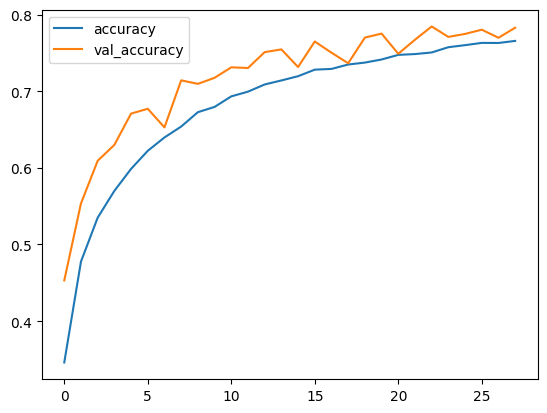

In [16]:
plt.plot(best_combination[1][2].history['accuracy'], label='accuracy')
plt.plot(best_combination[1][2].history['val_accuracy'], label='val_accuracy')
plt.legend()

### Plot loss per iteration

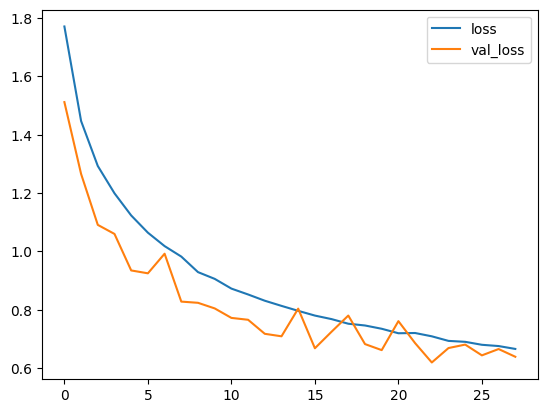

In [17]:
plt.plot(best_combination[1][2].history['loss'], label='loss')
plt.plot(best_combination[1][2].history['val_loss'], label='val_loss')
plt.legend()

### Train the tuned model on entire train set and test using the test set

In [19]:
# Define Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, verbose=1,  restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    filepath='cnn_model.h5'
)

# Build the model
model = create_Model1(best_combination[0][0], best_combination[0][1], best_combination[0][2])


batch_size = 128
steps_per_epoch = X_train.shape[0] // batch_size
num_epochs = 40

 # Define Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, verbose=1,  restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    filepath='cnn_model.h5'
)


# Train CNN on the training data
r = model.fit(X_train, Y_train, steps_per_epoch=steps_per_epoch, epochs = num_epochs, batch_size=batch_size, callbacks=[checkpoint_callback, callback])

# Load the best model
best_model = load_model('cnn_model.h5')


test_loss, test_accuracy = best_model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1)

Epoch 1/40
390/390 [==============================] - ETA: 0s - loss: 1.5194 - accuracy: 0.4477
Epoch 1: accuracy improved from -inf to 0.44766, saving model to cnn_model.h5
390/390 [==============================] - 50s 124ms/step - loss: 1.5194 - accuracy: 0.4477
Epoch 2/40
390/390 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.6253
Epoch 2: accuracy improved from 0.44766 to 0.62526, saving model to cnn_model.h5
390/390 [==============================] - 49s 125ms/step - loss: 1.0536 - accuracy: 0.6253
Epoch 3/40
390/390 [==============================] - ETA: 0s - loss: 0.8504 - accuracy: 0.7012
Epoch 3: accuracy improved from 0.62526 to 0.70124, saving model to cnn_model.h5
390/390 [==============================] - 48s 122ms/step - loss: 0.8504 - accuracy: 0.7012
Epoch 4/40
390/390 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.7474
Epoch 4: accuracy improved from 0.70124 to 0.74737, saving model to cnn_model.h5
390/390 [==========

Epoch 32/40
390/390 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9770
Epoch 32: accuracy improved from 0.97662 to 0.97702, saving model to cnn_model.h5
390/390 [==============================] - 49s 124ms/step - loss: 0.0697 - accuracy: 0.9770
Epoch 33/40
390/390 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9784
Epoch 33: accuracy improved from 0.97702 to 0.97840, saving model to cnn_model.h5
390/390 [==============================] - 48s 123ms/step - loss: 0.0650 - accuracy: 0.9784
Epoch 34/40
390/390 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9780
Epoch 34: accuracy did not improve from 0.97840
390/390 [==============================] - 48s 123ms/step - loss: 0.0656 - accuracy: 0.9780
Epoch 35/40
390/390 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9772
Epoch 35: accuracy did not improve from 0.97840
390/390 [==============================] - 48s 123ms/step - loss: 0.0665 - a

In [20]:
print("Testing accuracy: ", test_accuracy)

Testing accuracy:  0.7817999720573425


## Experiment 2

### Build model

In [8]:
def create_Model2(k, dr, lr):
    
    i = Input(shape = (32, 32, 3))

    x = Conv2D(32, (k,k), activation= 'relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (k,k), activation= 'relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(dr)(x)

    x = Conv2D(64, (k,k), activation= 'relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (k,k), activation= 'relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(dr)(x)
    
    x = Conv2D(128, (k,k), activation= 'relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (k,k), activation= 'relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(dr)(x)
    
    x = Conv2D(256, (k,k), activation= 'relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (k,k), activation= 'relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(dr)(x)

    x = Flatten()(x)
    
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dr)(x)

    x = Dense(10, activation='softmax')(x)
    

    model = Model(i,x)
    
    opt = keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        

    return model

### Model summary with filter size as 3x3, dropout rate as 0.20 and learning rate as 0.01

In [9]:
create_Model2(3, 0.20, 0.01).summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0   

### Perform hyper-parameter tuning

In [26]:
# Get the three combinations that performed the best in experiment 1

accuracies = []

for key, value in results.items():
    if 'accuracy' in value:
        accuracies.append((key, value['accuracy']))

accuracies.sort(key=lambda x: x[1], reverse=True)

combinations = [item[0] for item in accuracies[:5]]

print("The top three combinations from experiment 1 in descending order: ", combinations)

The top three combinations from experiment 1 in descending order:  [(3, 0.2, 0.001), (5, 0.35, 0.001), (5, 0.2, 0.001)]


In [27]:
results = {}

for combination in combinations:
    results[combination[0], combination[1], combination[2]] = {'accuracy': 0,  'loss': 0, 'history': None}

In [28]:
best_combination = [ [0, 0, 0], [0, 0, None] ]

In [29]:
for combination in combinations:
            
    print("\n" + f"COMBINATION: filter_size={combination[0]}, dropout_rate={combination[1]}, learning_rate={combination[2]}")

    # Initialise batch size, steps per epoch, number of epochs
    batch_size = 128
    steps_per_epoch = X_train_set.shape[0] // batch_size
    num_epochs = 50

     # Define Callback
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, verbose=1,  restore_best_weights=True)

    # Define the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1,
        filepath='cnn_model.h5'
    )

    # Build the model
    model = create_Model2(combination[0], combination[1], combination[2])

    # Train CNN on the training data
    r = model.fit(train_generator, validation_data=(X_val, Y_val), steps_per_epoch=steps_per_epoch, epochs = num_epochs, batch_size=batch_size, callbacks=[checkpoint_callback, callback])

    # Load the best model
    best_model = load_model('cnn_model.h5')

    # Evaluate on the validation data
    val_loss, val_accuracy = best_model.evaluate(X_val, Y_val)

    results[combination[0], combination[1], combination[2]] = {'accuracy': val_accuracy,  'loss': val_loss, 'history': r}

    print("COMBINATION BEST ACCURACY: ", val_accuracy)

    if val_accuracy > best_combination[1][0]:
        best_combination = [ [combination[0], combination[1], combination[2]], [val_accuracy, val_loss, r] ]

            



COMBINATION: filter_size=3, dropout_rate=0.2, learning_rate=0.001
Epoch 1/50
312/312 [==============================] - ETA: 0s - loss: 1.8504 - accuracy: 0.3573
Epoch 1: val_accuracy improved from -inf to 0.16420, saving model to cnn_model.h5
312/312 [==============================] - 69s 210ms/step - loss: 1.8504 - accuracy: 0.3573 - val_loss: 3.4646 - val_accuracy: 0.1642
Epoch 2/50
312/312 [==============================] - ETA: 0s - loss: 1.3902 - accuracy: 0.4960
Epoch 2: val_accuracy improved from 0.16420 to 0.56540, saving model to cnn_model.h5
312/312 [==============================] - 64s 205ms/step - loss: 1.3902 - accuracy: 0.4960 - val_loss: 1.2422 - val_accuracy: 0.5654
Epoch 3/50
312/312 [==============================] - ETA: 0s - loss: 1.1942 - accuracy: 0.5734
Epoch 3: val_accuracy improved from 0.56540 to 0.60170, saving model to cnn_model.h5
312/312 [==============================] - 70s 223ms/step - loss: 1.1942 - accuracy: 0.5734 - val_loss: 1.1690 - val_accuracy

Epoch 28/50
312/312 [==============================] - ETA: 0s - loss: 0.4555 - accuracy: 0.8422
Epoch 28: val_accuracy improved from 0.83450 to 0.86670, saving model to cnn_model.h5
312/312 [==============================] - 101s 324ms/step - loss: 0.4555 - accuracy: 0.8422 - val_loss: 0.4050 - val_accuracy: 0.8667
Epoch 29/50
312/312 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8447
Epoch 29: val_accuracy did not improve from 0.86670
312/312 [==============================] - 110s 353ms/step - loss: 0.4481 - accuracy: 0.8447 - val_loss: 0.4741 - val_accuracy: 0.8409
Epoch 30/50
312/312 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8474
Epoch 30: val_accuracy did not improve from 0.86670
312/312 [==============================] - 112s 358ms/step - loss: 0.4411 - accuracy: 0.8474 - val_loss: 0.4515 - val_accuracy: 0.8502
Epoch 31/50
312/312 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8528
Epoch 31: val_acc

312/312 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.7868
Epoch 18: val_accuracy did not improve from 0.79900
312/312 [==============================] - 176s 565ms/step - loss: 0.6352 - accuracy: 0.7868 - val_loss: 0.6347 - val_accuracy: 0.7909
Epoch 19/50
312/312 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7938
Epoch 19: val_accuracy improved from 0.79900 to 0.82340, saving model to cnn_model.h5
312/312 [==============================] - 173s 553ms/step - loss: 0.6042 - accuracy: 0.7938 - val_loss: 0.5175 - val_accuracy: 0.8234
Epoch 20/50
312/312 [==============================] - ETA: 0s - loss: 0.5990 - accuracy: 0.7973
Epoch 20: val_accuracy did not improve from 0.82340
312/312 [==============================] - 171s 547ms/step - loss: 0.5990 - accuracy: 0.7973 - val_loss: 0.7271 - val_accuracy: 0.7670
Epoch 21/50
312/312 [==============================] - ETA: 0s - loss: 0.5897 - accuracy: 0.8024
Epoch 21: val_accuracy did no

312/312 [==============================] - ETA: 0s - loss: 0.4267 - accuracy: 0.8533
Epoch 46: val_accuracy did not improve from 0.85980
312/312 [==============================] - 172s 549ms/step - loss: 0.4267 - accuracy: 0.8533 - val_loss: 0.4664 - val_accuracy: 0.8434
Epoch 47/50
312/312 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.8567
Epoch 47: val_accuracy did not improve from 0.85980
312/312 [==============================] - 169s 540ms/step - loss: 0.4231 - accuracy: 0.8567 - val_loss: 0.4818 - val_accuracy: 0.8415
Epoch 48/50
312/312 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.8542
Epoch 48: val_accuracy did not improve from 0.85980
312/312 [==============================] - 166s 533ms/step - loss: 0.4257 - accuracy: 0.8542 - val_loss: 0.4094 - val_accuracy: 0.8585
Epoch 49/50
312/312 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8529
Epoch 49: val_accuracy did not improve from 0.85980
312/312 [==

Epoch 23/50
312/312 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.8402
Epoch 23: val_accuracy did not improve from 0.83880
312/312 [==============================] - 163s 523ms/step - loss: 0.4655 - accuracy: 0.8402 - val_loss: 0.6291 - val_accuracy: 0.7965
Epoch 24/50
312/312 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.7970
Epoch 24: val_accuracy did not improve from 0.83880
312/312 [==============================] - 162s 519ms/step - loss: 0.6103 - accuracy: 0.7970 - val_loss: 0.5981 - val_accuracy: 0.7991
Epoch 25/50
312/312 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.8261
Epoch 25: val_accuracy did not improve from 0.83880
312/312 [==============================] - 162s 520ms/step - loss: 0.5059 - accuracy: 0.8261 - val_loss: 0.5135 - val_accuracy: 0.8225
Epoch 26/50
312/312 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.8309
Epoch 26: val_accuracy did not improve from 0.83880

In [30]:
print(results)

{(3, 0.2, 0.001): {'accuracy': 0.8666999936103821, 'loss': 0.40497228503227234, 'history': <keras.src.callbacks.History object at 0x000002152F22B0A0>}, (5, 0.35, 0.001): {'accuracy': 0.8597999811172485, 'loss': 0.4356762170791626, 'history': <keras.src.callbacks.History object at 0x000002154B3987C0>}, (5, 0.2, 0.001): {'accuracy': 0.8388000130653381, 'loss': 0.4791260361671448, 'history': <keras.src.callbacks.History object at 0x000002155A902830>}}


### Combination with best accuracy

In [31]:
print("\n" + f"COMBINATION: filter_size={best_combination[0][0]}, dropout_rate={best_combination[0][1]}, learning_rate={best_combination[0][2]}")
print("Accuracy: ", best_combination[1][0])


COMBINATION: filter_size=3, dropout_rate=0.2, learning_rate=0.001
Accuracy:  0.8666999936103821


### Plot Accuracy per iteration

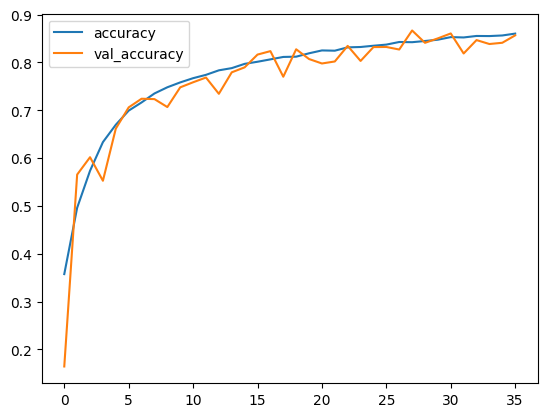

In [32]:
plt.plot(best_combination[1][2].history['accuracy'], label='accuracy')
plt.plot(best_combination[1][2].history['val_accuracy'], label='val_accuracy')
plt.legend()

### Plot loss per iteration

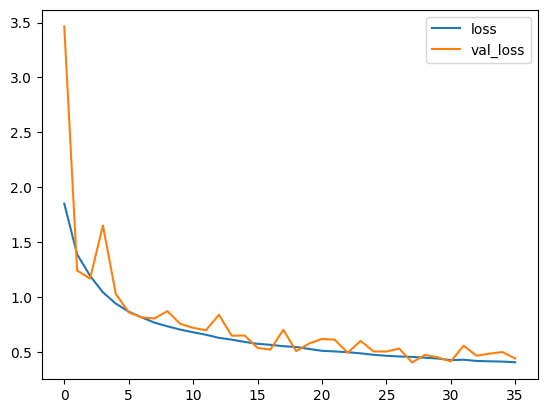

In [33]:
plt.plot(best_combination[1][2].history['loss'], label='loss')
plt.plot(best_combination[1][2].history['val_loss'], label='val_loss')
plt.legend()

### Train the tuned model on entire train set and test using the test set

In [34]:
# Build the model
model = create_Model2(best_combination[0][0], best_combination[0][1], best_combination[0][2])


batch_size = 128
steps_per_epoch = X_train.shape[0] // batch_size
num_epochs = 50

 # Define Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=8, verbose=1,  restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    filepath='cnn_model.h5'
)


# Train CNN on the training data
r = model.fit(X_train, Y_train, steps_per_epoch=steps_per_epoch, epochs = num_epochs, batch_size=batch_size, callbacks=[checkpoint_callback, callback])

# Load the best model
best_model = load_model('cnn_model.h5')


test_loss, test_accuracy = best_model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1)

Epoch 1/50
390/390 [==============================] - ETA: 0s - loss: 1.4957 - accuracy: 0.4807
Epoch 1: accuracy improved from -inf to 0.48075, saving model to cnn_model.h5
390/390 [==============================] - 83s 202ms/step - loss: 1.4957 - accuracy: 0.4807
Epoch 2/50
390/390 [==============================] - ETA: 0s - loss: 0.9651 - accuracy: 0.6579
Epoch 2: accuracy improved from 0.48075 to 0.65788, saving model to cnn_model.h5
390/390 [==============================] - 75s 193ms/step - loss: 0.9651 - accuracy: 0.6579
Epoch 3/50
390/390 [==============================] - ETA: 0s - loss: 0.7699 - accuracy: 0.7294
Epoch 3: accuracy improved from 0.65788 to 0.72943, saving model to cnn_model.h5
390/390 [==============================] - 80s 205ms/step - loss: 0.7699 - accuracy: 0.7294
Epoch 4/50
390/390 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.7683
Epoch 4: accuracy improved from 0.72943 to 0.76835, saving model to cnn_model.h5
390/390 [==========

Epoch 32/50
390/390 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9672
Epoch 32: accuracy improved from 0.96525 to 0.96722, saving model to cnn_model.h5
390/390 [==============================] - 71s 181ms/step - loss: 0.0962 - accuracy: 0.9672
Epoch 33/50
390/390 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9696
Epoch 33: accuracy improved from 0.96722 to 0.96958, saving model to cnn_model.h5
390/390 [==============================] - 72s 183ms/step - loss: 0.0916 - accuracy: 0.9696
Epoch 34/50
390/390 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9698
Epoch 34: accuracy improved from 0.96958 to 0.96976, saving model to cnn_model.h5
390/390 [==============================] - 72s 185ms/step - loss: 0.0914 - accuracy: 0.9698
Epoch 35/50
390/390 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9708
Epoch 35: accuracy improved from 0.96976 to 0.97081, saving model to cnn_model.h5
390/390 

In [35]:
print("Testing accuracy: ", test_accuracy)

Testing accuracy:  0.8514000177383423
